In [1]:
# !nvidia-smi

In [2]:
import transformers
from transformers import RobertaModel, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
import random
import os
import math
import re
import string
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold,StratifiedKFold

import gc

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)



def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
TRAIN_PATH = '../input/commonlitreadabilityprize/train.csv'
TEST_PATH = "../input/commonlitreadabilityprize/test.csv"
TARGET = "target"
PRE_TRAINED_MODEL_NAME = '../input/roberta-base'

In [4]:
df = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)
df_original = df.copy()
df = df.rename({'excerpt': 'text'}, axis=1)
df_test = df_test.rename({'excerpt': 'text'}, axis=1)
df_test[TARGET] = 0

df.head()

,id,url_legal,license,text,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [5]:
# df2 = pd.read_csv("../input/common-translated-data/train_fr_en.csv")[['excerpt_fr_en', 'target']]
# df2 = df2.rename({'excerpt_fr_en': 'text'}, axis=1)
# df = df.append(df2)

In [6]:
# df2 = pd.read_csv("../input/common-translated-data/train_es_en.csv")[['excerpt_es_en', 'target']]
# df2 = df2.rename({'excerpt_es_en': 'text'}, axis=1)
# df = df.append(df2)

In [7]:
df.shape

(2834, 6)

In [8]:
# df.info()

In [9]:
# df['text'].str.split(' ').apply(len).plot(kind='hist', title='length distribution');

In [10]:
tokenizer = RobertaTokenizer.from_pretrained('../input/roberta-base')

In [11]:
token_lens = []

for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Max Len: 322
Avg Len: 218


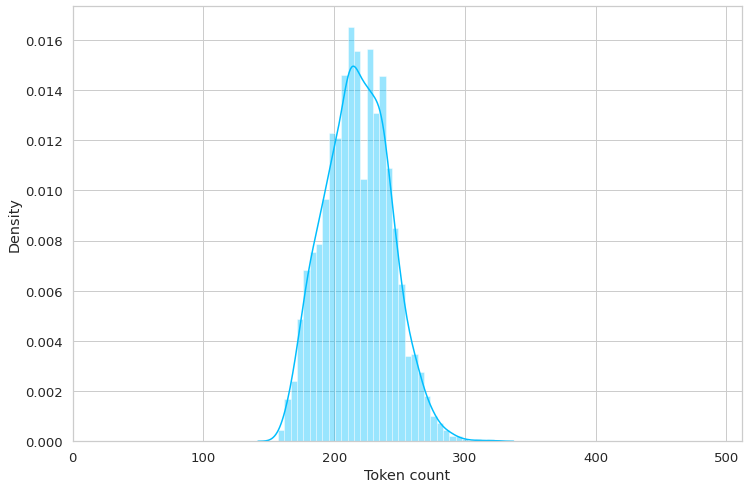

In [12]:
sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count')
print(f"Max Len: {max(token_lens)}\nAvg Len: {math.ceil(sum(token_lens)/len(token_lens))}")

In [13]:
MAX_LEN = 256

In [14]:
def rmse_score(y, X):
    return np.sqrt(mean_squared_error(y, X))

In [15]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.float)
    }

In [16]:
# df_train, df_val = train_test_split(df, test_size=0.01, random_state=RANDOM_SEED)
# df_train.shape, df_val.shape, df_test.shape

In [17]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    targets=df[TARGET].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [18]:
BATCH_SIZE = 256

# train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
# val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [19]:
class AttentionHead(nn.Module):
    def __init__(self, in_features, hidden_dim, num_targets):
        super().__init__()
        self.in_features = in_features
        self.middle_features = hidden_dim

        self.W = nn.Linear(in_features, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)
        self.out_features = hidden_dim

    def forward(self, features):
        att = torch.tanh(self.W(features))

        score = self.V(att)

        attention_weights = torch.softmax(score, dim=1)

        context_vector = attention_weights * features
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector

In [20]:
class Model(nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.roberta = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.head = AttentionHead(768, 768, 1)
    self.dropout = nn.Dropout(0.1)
    self.linear = nn.Linear(self.head.out_features, 1)
  
  def forward(self, input_ids, attention_mask):
    roberta_out = self.roberta(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
    
    last_hidden_state = roberta_out[0] 
    pooled_output = roberta_out[1]
    hidden_state = roberta_out[2][0]
    
    output = self.head(last_hidden_state)
#     output = self.dropout(output)
#     output = self.linear(output)
    return output

In [21]:
def get_featuers(model, data_loader,  device=device):
  model = model.eval()
  preds = []
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device).float()

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      outputs = outputs.detach().cpu().numpy()
      preds.extend(outputs)
  return np.array(preds)

In [22]:
def get_preds_svr(X, y, X_test, bins=None, nfolds=10, C=8, kernel='rbf'):
    scores = list()
    preds = np.zeros((X_test.shape[0]))
    
    kfold = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=RANDOM_SEED)
    for k, (train_idx, valid_idx) in enumerate(kfold.split(X, bins)):
        svr = SVR(C=C, kernel=kernel, gamma='auto')
        X_train,y_train = X[train_idx], y[train_idx]
        X_valid,y_valid = X[valid_idx], y[valid_idx]
        
        svr.fit(X_train, y_train)
        prediction = svr.predict(X_valid)
        score = rmse_score(prediction,y_valid)
        print(f'Fold {k} , rmse score: {score}')
        scores.append(score)
        preds += svr.predict(X_test)
       
    mean_score = np.mean(scores)
    print("mean rmse",mean_score)
    return np.array(preds)/nfolds, mean_score

In [23]:
num_bins = int(np.floor(1 + np.log2(len(df))))
df.loc[:,'bins'] = pd.cut(df['target'],bins=num_bins,labels=False)

target = df['target'].to_numpy()
bins = df.bins.to_numpy()
bins.shape

(2834,)

In [24]:
data_loader = create_data_loader(df, tokenizer, MAX_LEN, BATCH_SIZE)
preds = np.zeros((df_test.shape[0]))
mean_scores = []

for i in [0, 1, 3]:
    model = Model()
    model.load_state_dict(torch.load(f'../input/clr-roberta/model{i}/model{i}.bin'))
    model = model.to(device)
    features_train = get_featuers(model, data_loader,  device=device)
    features_test = get_featuers(model, test_data_loader,  device=device)
    preds_out, mean_score = get_preds_svr(features_train, df[TARGET].to_numpy(), features_test, bins=bins)
    preds += preds_out
    mean_scores.append(mean_score)
preds = preds / 3
print(f"Overall mean rmse {np.mean(mean_scores)}")

Some weights of the model checkpoint at ../input/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold 0 , rmse score: 0.49448220890566325
Fold 1 , rmse score: 0.4419003045781885
Fold 2 , rmse score: 0.2935939521346294
Fold 3 , rmse score: 0.2661541511826374
Fold 4 , rmse score: 0.2650865970100744
Fold 5 , rmse score: 0.2768245400988883
Fold 6 , rmse score: 0.2638245142014809
Fold 7 , rmse score: 0.2616547032558337
Fold 8 , rmse score: 0.2766408868946108
Fold 9 , rmse score: 0.279702294660336
mean rmse 0.31198641529223425


Some weights of the model checkpoint at ../input/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold 0 , rmse score: 0.25298210906544
Fold 1 , rmse score: 0.24037906750015833
Fold 2 , rmse score: 0.512382650893887
Fold 3 , rmse score: 0.4884292054681427
Fold 4 , rmse score: 0.2514560574157386
Fold 5 , rmse score: 0.227141152661907
Fold 6 , rmse score: 0.2292568615427005
Fold 7 , rmse score: 0.22940578301064024
Fold 8 , rmse score: 0.22556969150941775
Fold 9 , rmse score: 0.2565684180489916
mean rmse 0.29135709971170237


Some weights of the model checkpoint at ../input/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold 0 , rmse score: 0.3066218599398731
Fold 1 , rmse score: 0.2691128635579357
Fold 2 , rmse score: 0.27714768919597826
Fold 3 , rmse score: 0.28269655270727945
Fold 4 , rmse score: 0.25922452957677333
Fold 5 , rmse score: 0.30819712520884573
Fold 6 , rmse score: 0.44268858483994
Fold 7 , rmse score: 0.4497119060067375
Fold 8 , rmse score: 0.29567159061071097
Fold 9 , rmse score: 0.29813893162150085
mean rmse 0.31892116332655746
Overall mean rmse 0.30742155944349797


In [25]:
# NUM_MODELS = 5
# for i in range(NUM_MODELS):
#     roberta_preds = np.zeros((NUM_MODELS, len(df_test)))
#     model = Model()
#     model.load_state_dict(torch.load(f'../input/clr-roberta/model{i}/model{i}.bin'))
#     model = model.to(device)
#     roberta_preds[i] = get_featuers(model, test_data_loader,  device=device).reshape(-1)
# roberta_preds = roberta_preds.mean(axis=0)

In [26]:
# preds = preds * 5
# roberta_preds = roberta_preds.reshape(-1)
# new_preds = preds * 0.6 + roberta_preds * 0.4

In [27]:
submission = pd.DataFrame()
submission['id'] = df_test['id']
submission[TARGET] = preds.astype(float)
submission[TARGET] = round(submission[TARGET], 6)
submission.to_csv("submission.csv", index=False)
submission

,id,target
0,c0f722661,-0.376941
1,f0953f0a5,-0.681850
2,0df072751,-0.431051
3,04caf4e0c,-2.446665
4,0e63f8bea,-1.767920
5,12537fe78,-1.316993
6,965e592c0,0.290781
